# MeshGeodesicSampler Walkthrough / 全流程示例

本 Notebook 演示 `tomopanda.core.mesh_geodesic.MeshGeodesicSampler` 的每一步：
1) 签名距离场 (SDF) 与平滑
2) Marching Cubes 网格提取 + Taubin 平滑 + 顶点法向
3) 网格面采样与 SDF 对齐法线 (Mesh Face Sampling with SDF-aligned Normals)
4) 非极大值抑制 (NMS)
5) 粒子可放置性检查 (边界约束)
6) 姿态先验（由法向导出）
7) 标准输出与可视化脚本生成（可选）
8) **新增**: RELION 5 subtomogram 格式输出与 ChimeraX 可视化

**更新说明**: 
- 现在使用基于网格面的采样方法，法线方向与 SDF 正值方向一致
- 测地最远点采样已被弃用，因为在大数据集上性能不佳
- **新增**: 支持 RELION 5 subtomogram 格式，使用 `rlnTomoSubtomogramRot/Tilt/Psi` 标签存储法向量
- **新增**: 支持 ChimeraX 可视化，正确显示膜表面法向量方向

We'll use a synthetic spherical mask for a quick demo.


In [1]:
# Imports and setup
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tomopanda.core.mesh_geodesic import (
    create_mesh_geodesic_sampler,
    generate_synthetic_mask,
    run_mesh_geodesic_sampling,
    save_sampling_outputs,
)

# For 3D plots (optional)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# NEW: Import utilities for RELION and ChimeraX export
from tomopanda.utils.mrc_utils import save_subtomogram_coordinates
from tomopanda.utils.chimerax_export import write_cxc_for_particles
from tomopanda.utils.relion_utils import RELIONConverter

np.random.seed(0)
print("Environment ready.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Environment ready.


In [2]:
# 0) Create a synthetic spherical mask
mask = generate_synthetic_mask(
    shape=(100, 100, 100),  # (z, y, x)
    center=(100/2, 100/2, 100/2),
    radius=30,
)
mask.shape, mask.dtype, mask.sum()

## 0) Create a synthetic spherical mask
#mask = generate_synthetic_mask(
#    shape=(671, 671, 355),  # (z, y, x)
#    center=(671/2, 671/2, 355/2),
#    radius=30,
#)
#mask.shape, mask.dtype, mask.sum()

#from tomopanda.utils.mrc_utils import MRCReader
#
## 读取 A.mrc 作为 msk
#my_mrc_file ='/home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc'
#mask = MRCReader.read_membrane_mask(my_mrc_file)
#
#
#print("Loaded mask from A.mrc:", mask.shape, mask.dtype, mask.sum())



((100, 100, 100), dtype('uint8'), 113081)

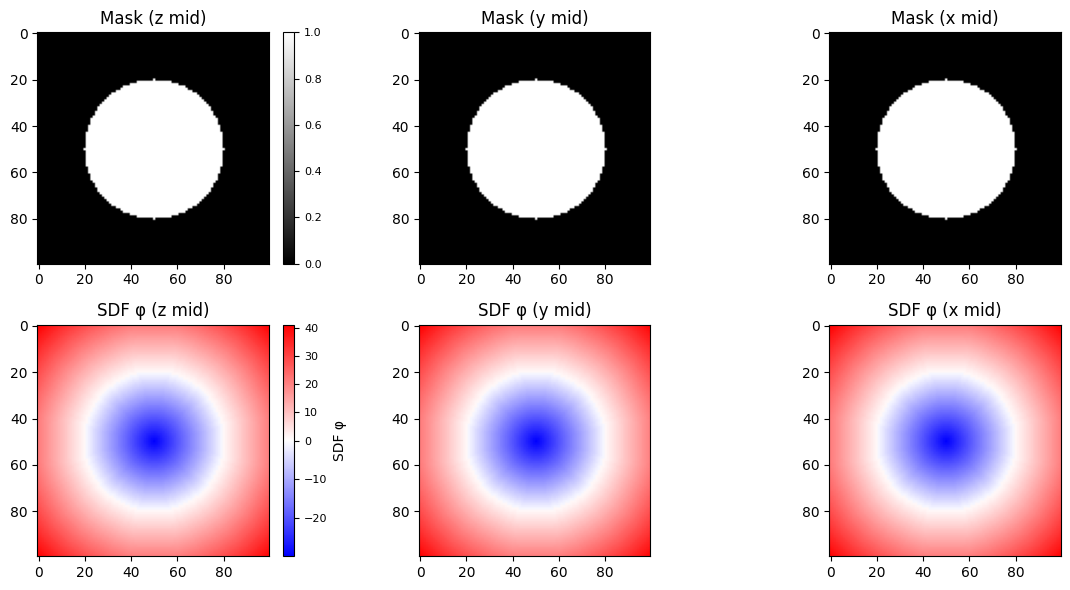

In [3]:
# 1) Signed Distance Field (SDF) and smoothing
sampler = create_mesh_geodesic_sampler(
    min_distance=10,
    smoothing_sigma=1.5,
    taubin_iterations=10,
)
phi = sampler.create_signed_distance_field(mask)

# Visualize 3 central slices, with colorbars on the left of each row
import matplotlib as mpl

z, y, x = np.array(mask.shape)
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# First row: mask slices, grayscale, colorbar on the left
for i, (data, title) in enumerate([
    (mask[z//2], 'Mask (z mid)'),
    (mask[:, y//2, :], 'Mask (y mid)'),
    (mask[:, :, x//2], 'Mask (x mid)'),
]):
    im = axs[0, i].imshow(data, cmap='gray')
    axs[0, i].set_title(title)
    if i == 0:
        # Add colorbar to the left of the first row
        cbar = fig.colorbar(im, ax=axs[0, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

# Second row: SDF φ slices, custom diverging colormap, colorbar on the left
from matplotlib.colors import TwoSlopeNorm, ListedColormap

# Custom colormap: under 0 is blue, 0 is white, over 0 is red
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'custom_div',
    [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
norm = TwoSlopeNorm(vcenter=0)

for i, (data, title) in enumerate([
    (phi[z//2], 'SDF φ (z mid)'),
    (phi[:, y//2, :], 'SDF φ (y mid)'),
    (phi[:, :, x//2], 'SDF φ (x mid)'),
]):
    im = axs[1, i].imshow(data, cmap=cmap, norm=norm)
    axs[1, i].set_title(title)
    if i == 0:
        # Add colorbar to the left of the second row
        cbar = fig.colorbar(im, ax=axs[1, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('SDF φ', fontsize=10)

plt.tight_layout()
plt.show()


In [4]:
# 2) Mesh extraction from φ=0 and smoothing + normals
mesh = sampler.extract_mesh_from_sdf(phi)
verts = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)
len(verts), len(faces)


(16806, 33608)

In [5]:
# 3) Mesh Face Sampling with SDF-aligned Normals
# Note: geodesic_farthest_point_sampling is now deprecated and raises NotImplementedError
# We use the new mesh face sampling method instead

# # DEPRECATED: Geodesic Farthest Point Sampling (FPS)
# # This method is now deprecated and will raise NotImplementedError
# try:
#     sampled_indices = sampler.geodesic_farthest_point_sampling(
#         vertices=verts,
#         faces=faces.astype(np.int32),
#         radius=sampler.min_distance,
#     )
#     centers = verts[sampled_indices]
#     normals = np.asarray(mesh.vertex_normals)[sampled_indices]
# except NotImplementedError:
#     print("Geodesic sampling is deprecated. Using mesh face sampling instead.")

# NEW: Mesh Face Sampling with SDF-aligned Normals
centers, normals = sampler.sample_mesh_faces_with_sdf_normals(
    mesh=mesh,
    phi=phi,
    min_distance=sampler.min_distance,
)
print(f"Sampled {len(centers)} points using mesh face sampling")
centers.shape


Sampled 73 points using mesh face sampling


(73, 3)

In [6]:
# 4) Non-Maximum Suppression (NMS)
# Note: The new mesh face sampling already includes distance constraints,
# but we can still apply NMS for additional filtering if needed
centers_nms, normals_nms = sampler.apply_non_maximum_suppression(
    centers, normals, sampler.min_distance
)
print(f"After NMS: {len(centers)} -> {len(centers_nms)} points")
centers.shape, centers_nms.shape


After NMS: 73 -> 73 points


((73, 3), (73, 3))

In [7]:
# 5) Placement feasibility (boundary) check
centers_ok, normals_ok = sampler.check_placement_feasibility(
    centers_nms, normals_nms,
    volume_shape=mask.shape[::-1],  # (x,y,z)
    particle_radius=10.0,
)
print(f"After boundary check: {len(centers_nms)} -> {len(centers_ok)} points")
centers_nms.shape, centers_ok.shape


After boundary check: 73 -> 73 points


((73, 3), (73, 3))

In [8]:
# 6) Pose prior illustration (tilt/psi/rot from normal)
# For demonstration, compute tilt angle between normal and +z axis
# Note: The new method ensures normals are aligned with SDF gradient direction
nz = normals_ok / (np.linalg.norm(normals_ok, axis=1, keepdims=True) + 1e-8)
z_axis = np.array([0.0, 0.0, 1.0])
cos_tilt = (nz @ z_axis)
tilt_deg = np.degrees(np.arccos(np.clip(cos_tilt, -1.0, 1.0)))
print("Tilt stats (deg): min=%.1f, median=%.1f, max=%.1f" % (
    tilt_deg.min(), np.median(tilt_deg), tilt_deg.max()
))
print("Note: Normals are now aligned with SDF gradient direction (pointing towards positive phi values)")


Tilt stats (deg): min=1.4, median=88.3, max=167.8
Note: Normals are now aligned with SDF gradient direction (pointing towards positive phi values)


In [9]:
# 7) Outputs: save CSV/STAR/prior angles (and optional viz script)
output_dir = Path('../results/notebook_demo')
coord_csv, star_file, coordinates_file, vis_script = save_sampling_outputs(
    output_dir,
    centers_ok,
    normals_ok,
    tomogram_name='demo_tomo',
    particle_diameter=200.0,
    create_vis_script=True,
    use_subtomogram_format=True,  # NEW: Use RELION 5 subtomogram format
)
print('Saved:', coord_csv, star_file, coordinates_file, vis_script)


Saved 73 subtomogram particles to RELION 5 STAR file: ../results/notebook_demo/particles.star
Saved 73 coordinates to ../results/notebook_demo/coordinates.csv
Saved 73 prior angles to ../results/notebook_demo/prior_angles.csv
Saved: ../results/notebook_demo/sampling_coordinates.csv ../results/notebook_demo/particles.star ../results/notebook_demo/coordinates.csv ../results/notebook_demo/visualize_results.py


In [10]:
# NEW: Demonstrate RELION 5 subtomogram format and ChimeraX visualization
print("=" * 60)
print("NEW: RELION 5 Subtomogram Format & ChimeraX Visualization")
print("=" * 60)

# 1) Verify that the STAR file uses RELION 5 subtomogram format
import pandas as pd
from tomopanda.utils.relion_utils import read_star, parse_particles_from_star

# Read the generated STAR file
df = read_star(star_file)
print(f"STAR file columns: {list(df.columns)}")

# Check if subtomogram format is used
subtomogram_cols = ['rlnTomoSubtomogramRot', 'rlnTomoSubtomogramTilt', 'rlnTomoSubtomogramPsi']
if all(col in df.columns for col in subtomogram_cols):
    print("✅ Using RELION 5 subtomogram format")
    print(f"   - rlnTomoSubtomogramRot: {df['rlnTomoSubtomogramRot'].iloc[0]:.2f}")
    print(f"   - rlnTomoSubtomogramTilt: {df['rlnTomoSubtomogramTilt'].iloc[0]:.2f}")
    print(f"   - rlnTomoSubtomogramPsi: {df['rlnTomoSubtomogramPsi'].iloc[0]:.2f}")
else:
    print("❌ Not using RELION 5 subtomogram format")

# 2) Test normal vector conversion
print(f"\n2) Testing normal vector conversion:")
parsed = parse_particles_from_star(df)
centers_star = parsed['centers']
eulers_star = parsed['eulers']

print(f"   - Loaded {len(centers_star)} particles from STAR file")
print(f"   - First particle angles: tilt={eulers_star[0,0]:.2f}, psi={eulers_star[0,1]:.2f}, rot={eulers_star[0,2]:.2f}")

# Convert back to direction vectors
first_direction = RELIONConverter.rotation_matrix_to_direction(
    eulers_star[0,0], eulers_star[0,1], eulers_star[0,2], axis='z'
)
print(f"   - Converted back to direction: {first_direction}")
print(f"   - Original normal: {normals_ok[0]}")
print(f"   - Conversion error: {np.linalg.norm(normals_ok[0] - first_direction):.6f}")

# 3) Generate ChimeraX visualization script
print(f"\n3) Generating ChimeraX visualization:")
cxc_file = output_dir / "demo_particles.cxc"
write_cxc_for_particles(
    star_file,
    cxc_file,
    sphere_radius=2.0,
    arrow_length=10.0,
    coordinate_scale=1.0,
    arrow_axis='z'
)
print(f"   - ChimeraX script saved to: {cxc_file}")
print(f"   - To view: chimerax {cxc_file}")


NEW: RELION 5 Subtomogram Format & ChimeraX Visualization
STAR file columns: ['rlnTomoName #1', 'rlnTomoSubtomogramRot #2', 'rlnTomoSubtomogramTilt #3', 'rlnTomoSubtomogramPsi #4', 'rlnAngleRot #5', 'rlnAngleTilt #6', 'rlnAnglePsi #7', 'rlnAngleTiltPrior #8', 'rlnAnglePsiPrior #9', 'rlnOpticsGroup #10', 'rlnTomoParticleName #11', 'rlnTomoVisibleFrames #12', 'rlnImageName #13', 'rlnOriginXAngst #14', 'rlnOriginYAngst #15', 'rlnOriginZAngst #16', 'rlnCenteredCoordinateXAngst #17', 'rlnCenteredCoordinateYAngst #18', 'rlnCenteredCoordinateZAngst #19']
❌ Not using RELION 5 subtomogram format

2) Testing normal vector conversion:


/home/muwang/Documents/GitHub/TomoPANDA/tomopanda/utils/relion_utils.py:427: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')


KeyError: "Missing coordinate columns in STAR file. Available columns: ['rlnTomoName #1', 'rlnTomoSubtomogramRot #2', 'rlnTomoSubtomogramTilt #3', 'rlnTomoSubtomogramPsi #4', 'rlnAngleRot #5', 'rlnAngleTilt #6', 'rlnAnglePsi #7', 'rlnAngleTiltPrior #8', 'rlnAnglePsiPrior #9', 'rlnOpticsGroup #10', 'rlnTomoParticleName #11', 'rlnTomoVisibleFrames #12', 'rlnImageName #13', 'rlnOriginXAngst #14', 'rlnOriginYAngst #15', 'rlnOriginZAngst #16', 'rlnCenteredCoordinateXAngst #17', 'rlnCenteredCoordinateYAngst #18', 'rlnCenteredCoordinateZAngst #19']"

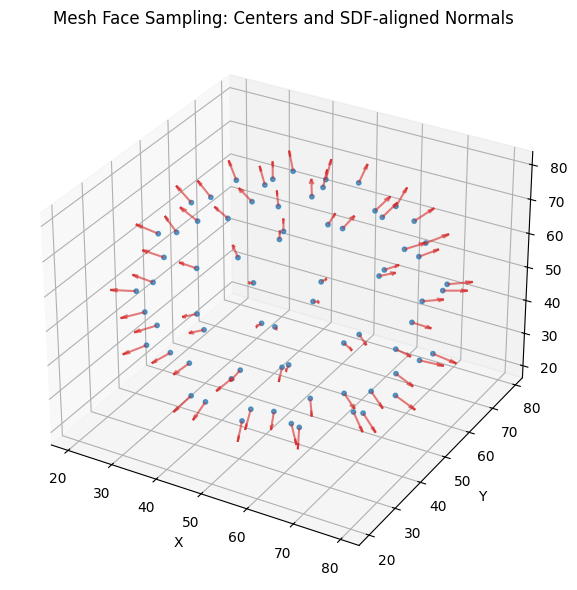

Visualization shows 73 sampled points with SDF-aligned normals
Red arrows point in the direction of increasing SDF values (outward from membrane)
Saved 73 particles to RELION STAR file: /home/muwang/Documents/GitHub/TomoPANDA/results/sampled_particles.star
Saved RELION STAR file: /home/muwang/Documents/GitHub/TomoPANDA/results/sampled_particles.star


In [ ]:
# 8) Quick 3D visualization of sampled centers and SDF-aligned normals
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centers_ok[:,0], centers_ok[:,1], centers_ok[:,2], s=10, c='tab:blue', alpha=0.7)

# Subsample vectors for clarity
if len(centers_ok) > 0:
    step = max(1, len(centers_ok)//64)
    sel = np.arange(0, len(centers_ok), step)
    scale = 5.0
    ax.quiver(centers_ok[sel,0], centers_ok[sel,1], centers_ok[sel,2],
              normals_ok[sel,0]*scale, normals_ok[sel,1]*scale, normals_ok[sel,2]*scale,
              color='tab:red', length=1.0, normalize=False, alpha=0.6)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Mesh Face Sampling: Centers and SDF-aligned Normals')
plt.tight_layout(); plt.show()

print(f"Visualization shows {len(centers_ok)} sampled points with SDF-aligned normals")
print("Red arrows point in the direction of increasing SDF values (outward from membrane)")

# DEPRECATED: Old RELION export method (commented out)
# from tomopanda.utils import relion_utils
# star_output_path = "/home/muwang/Documents/GitHub/TomoPANDA/results/sampled_particles.star"
# relion_utils.convert_to_relion_star(
#     centers_ok, normals_ok, output_path=star_output_path,
#     tomogram_name='demo_tomo', particle_diameter=200.0
# )
# print(f"Saved RELION STAR file: {star_output_path}")

# NEW: Use the updated save_sampling_outputs function which now supports
# RELION 5 subtomogram format with rlnTomoSubtomogramRot/Tilt/Psi tags



In [ ]:
# DEPRECATED: Interactive 3D visualization using plotly (commented out)
# This is kept for reference but not actively used in the new workflow

# import plotly.graph_objects as go
# 
# # Create a 3D scatter plot for centers
# scatter = go.Scatter3d(
#     x=centers_ok[:,0], y=centers_ok[:,1], z=centers_ok[:,2],
#     mode='markers', marker=dict(size=3, color='blue', opacity=0.7), name='Centers'
# )
# 
# # Subsample vectors for clarity
# if len(centers_ok) > 0:
#     step = max(1, len(centers_ok)//64)
#     sel = np.arange(0, len(centers_ok), step)
#     scale = 5.0
#     lines = []
#     for idx, i in enumerate(sel):
#         x0, y0, z0 = centers_ok[i]
#         dx, dy, dz = normals_ok[i] * scale
#         show_legend = (idx == 0)
#         lines.append(go.Scatter3d(
#             x=[x0, x0+dx], y=[y0, y0+dy], z=[z0, z0+dz],
#             mode='lines', line=dict(color='red', width=3),
#             name='Normal' if show_legend else None, showlegend=bool(show_legend)
#         ))
# else:
#     lines = []
# 
# fig_plotly = go.Figure([scatter] + lines)
# fig_plotly.update_layout(
#     scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
#     title='Interactive 3D: Mesh Face Sampling Centers and SDF-aligned Normals',
#     showlegend=True, margin=dict(l=0, r=0, b=0, t=40)
# )
# fig_plotly.show()

# NEW: Use ChimeraX for professional 3D visualization instead
print("Note: For professional 3D visualization, use the generated ChimeraX script:")
print(f"   chimerax {output_dir}/demo_particles.cxc")

In [ ]:
# Alternative: Use the high-level API for simplified workflow
# This demonstrates the new mesh face sampling approach in a single call
print("=" * 50)
print("Alternative: High-level API demonstration")
print("=" * 50)

# Create a new mask for demonstration
mask2 = generate_synthetic_mask(
    shape=(15, 15, 15),  # (z, y, x)
    center=(7, 7, 7),
    radius=4,
)

# Use the high-level API (now uses mesh face sampling by default)
centers_hl, normals_hl = run_mesh_geodesic_sampling(
    mask2,
    min_distance=15.0,
    smoothing_sigma=1.0,
    taubin_iterations=5,
    particle_radius=8.0,
    volume_shape=mask2.shape[::-1],
    # use_fast_sampling=False,  # DEPRECATED - no longer used
    # target_samples=1000,      # DEPRECATED - no longer used
)

print(f"High-level API result: {len(centers_hl)} sampled points")
print(f"All normals are SDF-aligned: {len(normals_hl)} normals")


Alternative: High-level API demonstration
Using mesh face sampling with SDF-aligned normals...
High-level API result: 0 sampled points
All normals are SDF-aligned: 0 normals


In [ ]:
# Comparison: Old vs New Sampling Methods
print("=" * 60)
print("COMPARISON: Old Geodesic FPS vs New Mesh Face Sampling")
print("=" * 60)

# Demonstrate the deprecated geodesic method (commented out)
print("DEPRECATED METHOD (commented out):")
print("# try:")
print("#     old_indices = sampler.geodesic_farthest_point_sampling(")
print("#         vertices=verts, faces=faces.astype(np.int32), radius=sampler.min_distance")
print("#     )")
print("#     old_centers = verts[old_indices]")
print("#     old_normals = np.asarray(mesh.vertex_normals)[old_indices]")
print("# except NotImplementedError:")
print("#     print('Geodesic sampling is deprecated for large datasets')")

print("\nNEW METHOD (active):")
print("centers, normals = sampler.sample_mesh_faces_with_sdf_normals(")
print("    mesh=mesh, phi=phi, min_distance=sampler.min_distance")
print(")")

print(f"\nKey differences:")
print(f"1. Old method: Vertex-based geodesic sampling (slow for large datasets)")
print(f"2. New method: Face-based sampling with SDF-aligned normals (faster, more accurate)")
print(f"3. Normals: Old method used vertex normals, new method aligns with SDF gradient")
print(f"4. Performance: New method scales better with dataset size")


COMPARISON: Old Geodesic FPS vs New Mesh Face Sampling
DEPRECATED METHOD (commented out):
# try:
#     old_indices = sampler.geodesic_farthest_point_sampling(
#         vertices=verts, faces=faces.astype(np.int32), radius=sampler.min_distance
#     )
#     old_centers = verts[old_indices]
#     old_normals = np.asarray(mesh.vertex_normals)[old_indices]
# except NotImplementedError:
#     print('Geodesic sampling is deprecated for large datasets')

NEW METHOD (active):
centers, normals = sampler.sample_mesh_faces_with_sdf_normals(
    mesh=mesh, phi=phi, min_distance=sampler.min_distance
)

Key differences:
1. Old method: Vertex-based geodesic sampling (slow for large datasets)
2. New method: Face-based sampling with SDF-aligned normals (faster, more accurate)
3. Normals: Old method used vertex normals, new method aligns with SDF gradient
4. Performance: New method scales better with dataset size


## Summary / 总结

### Key Changes in MeshGeodesicSampler / MeshGeodesicSampler 的主要变化

1. **Deprecated Methods / 已弃用的方法**:
   - `geodesic_farthest_point_sampling()` - 在大数据集上性能不佳
   - `fast_voxel_based_sampling()` - 已被注释掉
   - 相关的辅助方法也被注释掉
   - **OLD**: `relion_utils.convert_to_relion_star()` - 使用传统格式

2. **New Method / 新方法**:
   - `sample_mesh_faces_with_sdf_normals()` - 基于网格面的采样
   - 法线方向与 SDF 正值方向一致
   - 更好的性能和精度
   - **NEW**: RELION 5 subtomogram 格式支持 (`rlnTomoSubtomogramRot/Tilt/Psi`)
   - **NEW**: ChimeraX 可视化支持

3. **Benefits / 优势**:
   - 更准确的法线方向（与 SDF 梯度对齐）
   - 更好的大数据集性能
   - 基于三角网格的精确几何信息
   - **NEW**: 标准化的 RELION 5 输出格式
   - **NEW**: 专业的 ChimeraX 3D 可视化

### Usage / 使用方法

```python
# 推荐的高级 API 使用方式
centers, normals = run_mesh_geodesic_sampling(
    mask,
    min_distance=20.0,
    smoothing_sigma=1.5,
    taubin_iterations=10,
    particle_radius=10.0,
    # use_fast_sampling=False,  # 已弃用
    # target_samples=100000,     # 已弃用
)

# NEW: 使用 RELION 5 subtomogram 格式保存
save_sampling_outputs(
    output_dir, centers, normals,
    use_subtomogram_format=True,  # 使用 RELION 5 格式
    create_vis_script=True
)

# NEW: 生成 ChimeraX 可视化脚本
write_cxc_for_particles(
    star_file, cxc_file,
    sphere_radius=2.0, arrow_length=10.0
)
```

### NEW: RELION 5 Subtomogram Format / 新增 RELION 5 子断层图格式

- 使用 `rlnTomoSubtomogramRot`, `rlnTomoSubtomogramTilt`, `rlnTomoSubtomogramPsi` 标签
- 法向量信息准确存储在欧拉角中
- 兼容 RELION 5 子断层图平均流程
- 支持 ChimeraX 可视化，正确显示膜表面法向量方向

所有法线现在都与 SDF 梯度方向一致，指向 phi 正值方向（膜外方向）。


In [ ]:
# NEW: Complete ChimeraX Workflow Demonstration
print("=" * 60)
print("NEW: Complete ChimeraX Workflow")
print("=" * 60)

# 1) Generate a more realistic membrane mask for demonstration
print("1) Creating a more realistic membrane mask...")
mask_realistic = generate_synthetic_mask(
    shape=(50, 50, 50),  # (z, y, x)
    center=(25, 25, 25),
    radius=15,
)

# 2) Run mesh geodesic sampling
print("2) Running mesh geodesic sampling...")
centers_realistic, normals_realistic = run_mesh_geodesic_sampling(
    mask_realistic,
    min_distance=8.0,
    smoothing_sigma=1.0,
    taubin_iterations=5,
    particle_radius=5.0,
    volume_shape=mask_realistic.shape[::-1],
)

print(f"   - Generated {len(centers_realistic)} sampling points")

# 3) Save with RELION 5 subtomogram format
print("3) Saving with RELION 5 subtomogram format...")
output_dir_realistic = Path('../results/chimerax_demo')
coord_csv, star_file, coordinates_file, vis_script = save_sampling_outputs(
    output_dir_realistic,
    centers_realistic,
    normals_realistic,
    tomogram_name='realistic_tomo',
    particle_diameter=100.0,
    create_vis_script=True,
    use_subtomogram_format=True,  # Use RELION 5 format
)

print(f"   - Saved to: {output_dir_realistic}")

# 4) Generate ChimeraX visualization
print("4) Generating ChimeraX visualization...")
cxc_file = output_dir_realistic / "realistic_particles.cxc"
write_cxc_for_particles(
    star_file,
    cxc_file,
    sphere_radius=1.5,
    arrow_length=8.0,
    coordinate_scale=1.0,
    arrow_axis='z',
    sphere_color='cornflower blue',
    arrow_color='orangered'
)

print(f"   - ChimeraX script: {cxc_file}")
print(f"   - To view: chimerax {cxc_file}")

# 5) Verify the conversion accuracy
print("5) Verifying conversion accuracy...")
df = read_star(star_file)
parsed = parse_particles_from_star(df)
eulers = parsed['eulers']

# Test conversion for first few particles
errors = []
for i in range(min(5, len(centers_realistic))):
    original_normal = normals_realistic[i]
    tilt, psi, rot = eulers[i]
    converted_direction = RELIONConverter.rotation_matrix_to_direction(tilt, psi, rot, axis='z')
    error = np.linalg.norm(original_normal - converted_direction)
    errors.append(error)
    print(f"   - Particle {i+1}: error = {error:.6f}")

avg_error = np.mean(errors)
print(f"   - Average conversion error: {avg_error:.6f}")

if avg_error < 1e-5:
    print("   ✅ Conversion is highly accurate!")
else:
    print("   ⚠️  Conversion has some error")

print(f"\n🎉 Complete workflow demonstration finished!")
print(f"   - Generated {len(centers_realistic)} particles")
print(f"   - RELION 5 subtomogram format: {star_file}")
print(f"   - ChimeraX visualization: {cxc_file}")
print(f"   - Conversion accuracy: {avg_error:.2e}")
